In [1]:
from pathlib import Path
import sys
project_root = next((parent for parent in [Path.cwd()] + list(Path.cwd().parents) if (parent / "pyproject.toml").exists()), Path.cwd())
sys.path.append(str(project_root))

In [2]:
output_path = project_root / "aa2_perfect_1.parquet"

In [3]:
from llm_python.datasets.superking import load_superking

superking_df = load_superking()

Bucket: gs://trelis-arc/datasets/superking/
Found 84 parquet files in datasets/superking/
Downloaded 1 files, skipped 0 files (already present and unchanged)
Downloaded 2 files, skipped 0 files (already present and unchanged)
Downloaded 3 files, skipped 0 files (already present and unchanged)
Downloaded 4 files, skipped 0 files (already present and unchanged)
Downloaded 5 files, skipped 0 files (already present and unchanged)
Downloaded 6 files, skipped 0 files (already present and unchanged)
Downloaded 7 files, skipped 0 files (already present and unchanged)
Downloaded 8 files, skipped 0 files (already present and unchanged)
Downloaded 9 files, skipped 0 files (already present and unchanged)
Downloaded 10 files, skipped 0 files (already present and unchanged)
Downloaded 11 files, skipped 0 files (already present and unchanged)
Downloaded 12 files, skipped 0 files (already present and unchanged)
Downloaded 13 files, skipped 0 files (already present and unchanged)
Downloaded 14 files, s

In [4]:
superking_df = superking_df.drop(columns=["reasoning"])

In [5]:

from llm_python.datasets.query import filter_soar_df

df = superking_df.copy()
df = filter_soar_df(
    df,
    exclude_subset="arc-prize-2025/evaluation",
    all_train_correct=True,
    all_test_correct=True,
)


In [6]:
# Deduplicate df by task_id and code, preferring rows with refined_from_id notna
initial_len = len(df)
df = (
    df.sort_values(by="refined_from_id", na_position="last")  # refined rows first
      .drop_duplicates(subset=["task_id", "code"], keep="first")
      .reset_index(drop=True)
)
print(f"Deduplicated rows: {len(df) } (removed {initial_len - len(df)})")

Deduplicated rows: 113644 (removed 37009)


In [7]:
import numpy as np

from llm_python.datasets.query import sample_by_task

df["correct_train_input_count"] = df["correct_train_input"].apply(lambda x: np.sum(x))
df["correct_test_input_count"] = df["correct_test_input"].apply(lambda x: np.sum(x))
df["code_length"] = df["code"].str.len()

df = sample_by_task(
    df,
    sort_keys=["correct_test_input_count", "correct_train_input_count", "code_length"],
    sort_ascending=[False, False, True],
    task_limit=1,
)

In [8]:
print(len(df))
print(df.head())

730
                                  row_id   task_id  \
104736  8aadbba94c1d8f3421dbcb5de21a4e05  ff28f65a   
45092   f633e9fd1b6f4f6934059c6390c89d5e  27a28665   
49987   e9fe5ae2b282a39dcbc64a22eb156e9b  3cd86f4f   
32694   7f72da96dbcd6714255dfc540958fde2  af726779   
20896   a11e2d13c88ff2497dc0daea48bd5453  794b24be   

                                                     code  \
104736  import numpy as np
from scipy.ndimage import l...   
45092   def transform(grid):

    pattern = ''.join('1...   
49987   def transform(grid):
    n = len(grid)
    m =...   
32694   def transform(grid):

    out = [row[:] for ro...   
20896   def transform(grid):

    cnt = sum(cell == 1 ...   

                                      correct_train_input  \
104736  [ True  True  True  True  True  True  True  True]   
45092         [ True  True  True  True  True  True  True]   
49987                                 [ True  True  True]   
32694                                 [ True  True  True]   

In [9]:
from llm_python.datasets.io import write_soar_parquet
from llm_python.datasets.schema import PARQUET_SCHEMA

print(f"Saving final dataset to: {output_path}")
write_soar_parquet(df, output_path, schema=PARQUET_SCHEMA)

Saving final dataset to: /Users/ronanmcgovern/TR/arc-agi-2025/aa2_perfect_1.parquet


DATASET STATISTICS ANALYSIS: refinement
1. Computing basic statistics...
📊 Basic Statistics:
   • Unique tasks: 730
   • Total programs: 730
   • Fully correct programs: 730 (100.0%)
   • Partially correct programs: 0 (0.0%)
   • Completely incorrect programs: 0 (0.0%)
   • Average correctness rate: 1.000

2. Computing per-task distributions...
📈 Per-task Statistics:
   • Average programs per task: 1.0
   • Median programs per task: 1.0
   • Min programs per task: 1
   • Max programs per task: 1
   • Tasks with 1 programs (max): 730
   • Tasks with fully correct programs: 730
   • Tasks with no correct programs: 0

3. Computing quantile distribution of programs per task...
📊 Programs per Task - Quantile Distribution:
   • 0th percentile (min): 1.0
   • 25th percentile: 1.0
   • 50th percentile (median): 1.0
   • 75th percentile: 1.0
   • 90th percentile: 1.0
   • 95th percentile: 1.0
   • 99th percentile: 1.0
   • 100th percentile (max): 1.0

4. Creating visualizations...


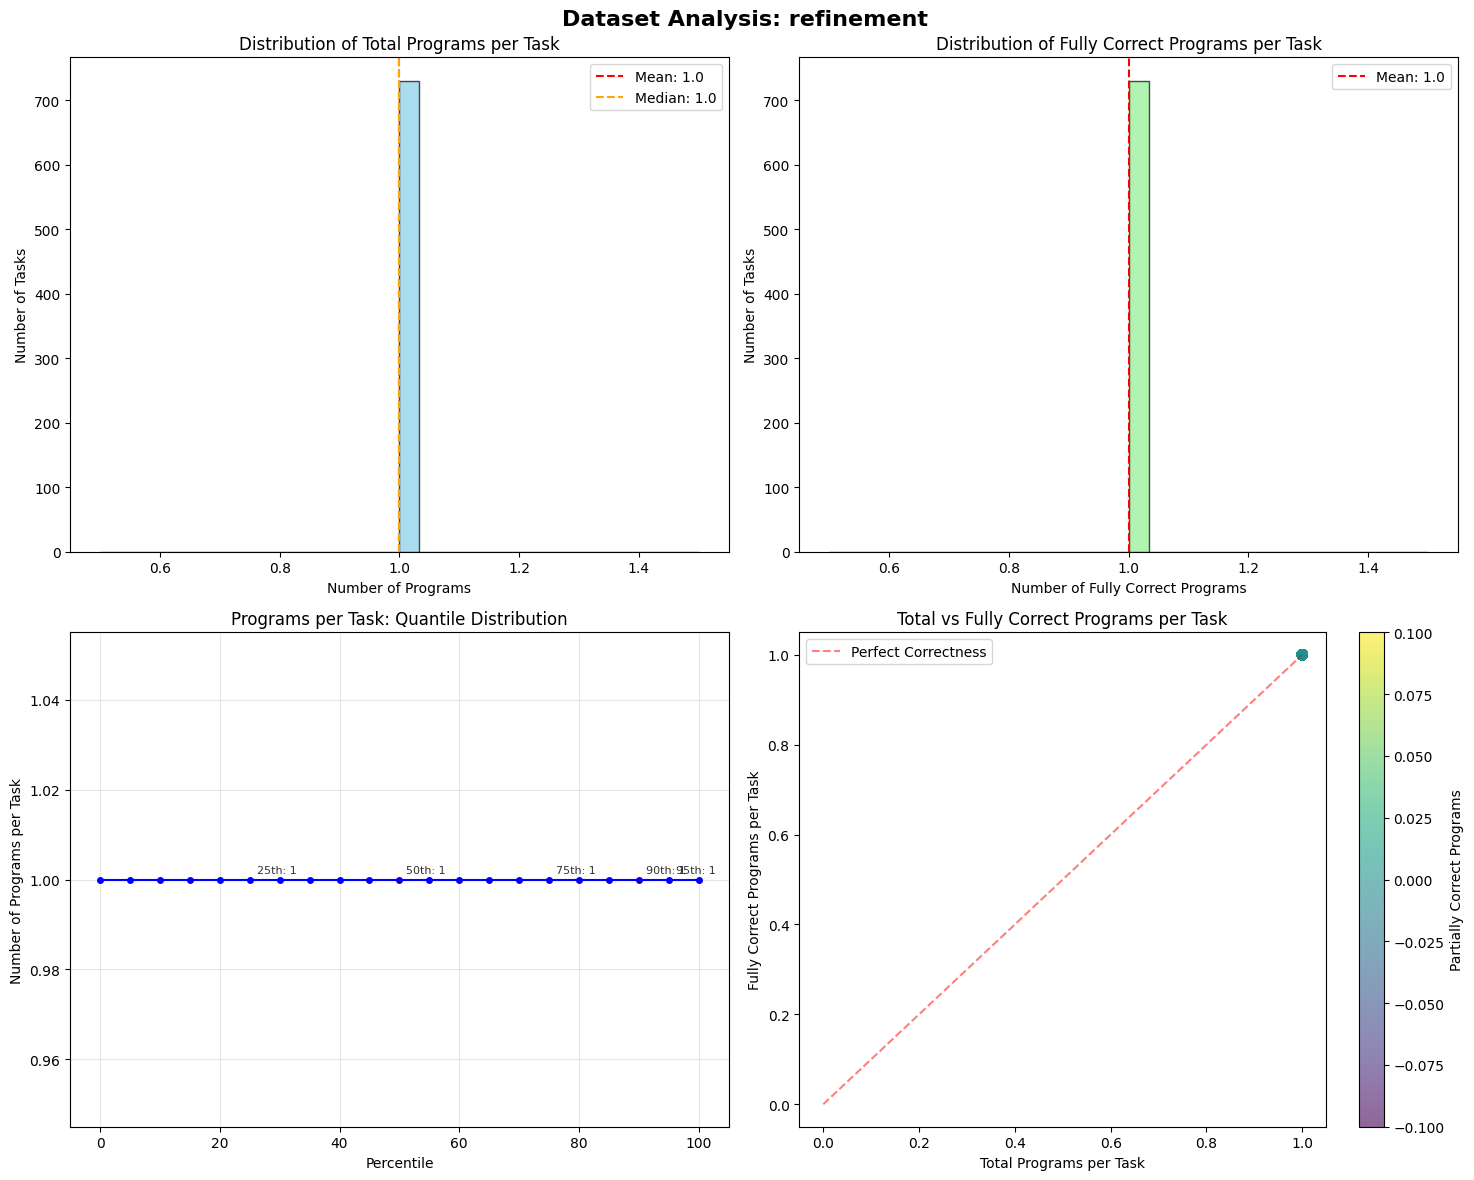


✓ Analysis complete! Generated visualizations showing:
   • Program distribution patterns across tasks
   • Quantile distribution of programs per task
   • Relationship between total and correct programs per task


In [10]:
from llm_python.datasets.statistics import analyze_dataset_statistics

analyze_dataset_statistics(df, "refinement")